#  FastEdit: Fast Text Guided Single Image Editing via Semantic-Aware Diffusion Fine-Tuning

![](../assets/teaser.png)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
import time
from PIL import Image
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm
from torchvision.transforms import ToTensor
from utils.image_utils import image_augmentations
from utils.model_utils import sample_image, decode_image, encode_image, configure_model, seed_everything

In [2]:
seed_everything(5679)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
accelerator = Accelerator(gradient_accumulation_steps=1, mixed_precision="fp16")

Using device: cuda


In [3]:
image = "assets/images/Mona_Lisa.jpg"
prompt = "A painting of Mona Lisa wearing a hat."

In [4]:
unet, optimizer, model_fine_tuning_optimization_steps, vae, scheduler, image_encoder, feature_extractor, text_embeddings = configure_model(
    "lora", device, prompt)

unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [5]:
aug_images = image_augmentations(image, ["none"], target_size=512)

In [6]:
aug_img_latents = []
for index, (aug_image, aug_cond) in enumerate(aug_images):
    # Move augmented image to device and encode
    img_tensor = aug_image.to(device).unsqueeze(0)
    latent_dist = vae.encode(img_tensor).latent_dist
    image_latents = latent_dist.sample(generator=torch.Generator())
    image_latents *= vae.config.scaling_factor
    
    aug_cond_tensor = aug_cond.to(device).unsqueeze(0)
    aug_image_embeddings = encode_image(aug_cond_tensor, device, image_encoder, feature_extractor)

    aug_img_latents.append((image_latents, aug_image_embeddings))
image_latents, _ = aug_img_latents[0]

unet, optimizer = accelerator.prepare(unet, optimizer)
progress_bar = tqdm(range(model_fine_tuning_optimization_steps))
progress_bar.set_description("Steps")
history = []
global_step = 0

cosine_similarity = F.cosine_similarity(text_embeddings, aug_img_latents[0][1], dim=-1).item()
score = round(cosine_similarity, 2)
print("Score:", score)

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Score: 0.24


In [7]:
timestep_values = [[200, 300, 400, 600], [200, 400, 600, 800], [300, 500, 600, 800]]

if score <= 0.18:
    timestep_value = timestep_values[2]
    print("Using High Timesteps")
elif score > 0.18 and score <= 0.24:
    timestep_value = timestep_values[1]
    print("Using Mid Timesteps")
elif score > 0.24:
    timestep_value = timestep_values[0]
    print("Using Low Timesteps")

batch_size = 4
image_latent = aug_img_latents[0][0].repeat(batch_size, 1, 1, 1)
image_embeddings = aug_img_latents[0][1].repeat(batch_size, 1, 1)


Using Mid Timesteps


In [8]:
model_fine_tuning_optimization_steps = 50
start_time = time.time()
for _ in range(model_fine_tuning_optimization_steps):
    unet.train()
    with accelerator.accumulate(unet):
        # Sample noise that we'll add to the latents
        batch_noise = torch.randn((batch_size,) + image_latents.shape[1:]).to(image_latents.device)

        batch_timesteps = torch.tensor(timestep_value, device=image_latents.device)

        noisy_latents = scheduler.add_noise(image_latent, batch_noise, batch_timesteps)

        # Predict the noise residual
        noise_pred = unet(noisy_latents, batch_timesteps, image_embeddings).sample

        loss = F.mse_loss(noise_pred, batch_noise, reduction="none").mean([1, 2, 3]).mean()
        accelerator.backward(loss)

        optimizer.step()
        optimizer.zero_grad()

    # Checks if the accelerator has performed an optimization step behind the scenes
    if accelerator.sync_gradients:
        progress_bar.update(1)
        global_step += 1

    logs = {"loss": loss.detach().item()}  # , "lr": lr_scheduler.get_last_lr()[0]}
    history.append(loss.detach().item())
    progress_bar.set_postfix(**logs)
    accelerator.log(logs, step=global_step)

    training_time = time.time() - start_time
    accelerator.wait_for_everyone()
print(f"Training Time: {training_time}")

Steps: 100%|██████████| 50/50 [00:15<00:00,  3.45it/s, loss=0.0661]

Training Time: 15.872045040130615


In [9]:
# Interpolate the embedding
images = []
save_prompt = prompt.replace(" ", "_")
ori_img = ToTensor()(decode_image(image_latents, vae))
images.append(ori_img)
num = 1
for alpha in np.arange(0.0, 1.1, 0.125):
    new_wmb = alpha * text_embeddings + (1 - alpha) * aug_img_latents[0][1]

    # generate image
    latents = sample_image(
        new_wmb,
        device,
        unet,
        scheduler,
        guidance_scale=2.5,
    )
    # decode image
    img = decode_image(latents, vae)
    img_tensor = ToTensor()(img)
    images.append(img_tensor)
    num += 1

images = torch.stack(images)
result = make_grid(images, nrow=5, padding=0, value_range=(0, 1))


Sampling: 100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


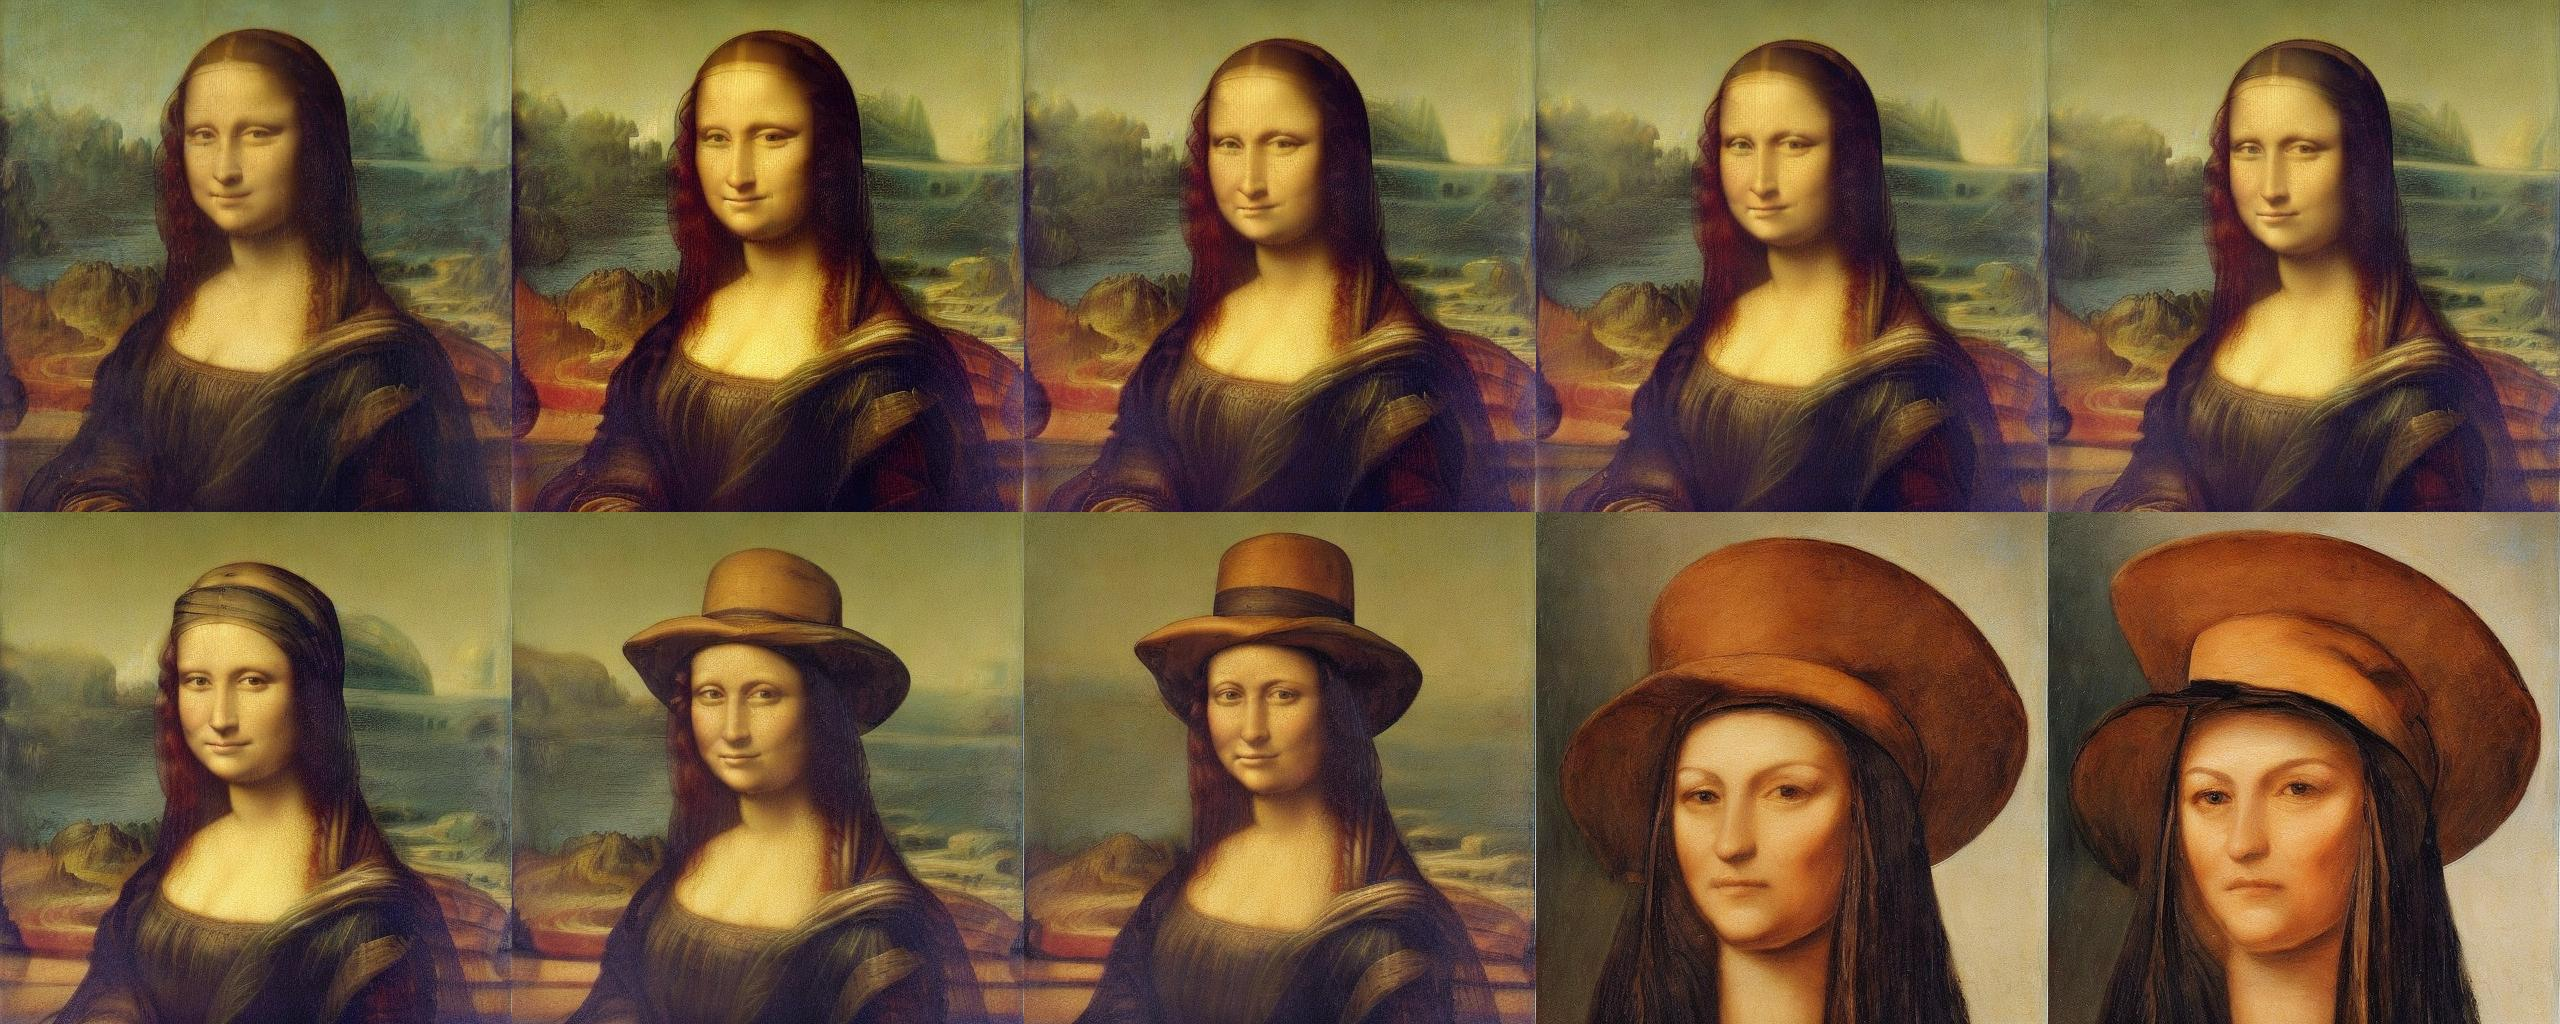

In [10]:
save_image(result,"1.jpeg")
display(Image.open("1.jpeg"))